In [3]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
import pandas as pd
import os
import glob
import matplotlib.pylab as plt
from pygam import PoissonGAM, s, te
from pygam.datasets import chicago
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines
from statsmodels.gam.tests.test_penalized import df_autos
from statsmodels.gam.smooth_basis import (BSplines, CubicSplines,
                                          CyclicCubicSplines)
from pygam import LinearGAM, s,f,te
from sklearn.metrics import PredictionErrorDisplay

from pygam.datasets import mcycle
from sklearn.metrics import mean_squared_error
from pickle import dump, load
import math
import pickle
import sys
import seaborn as sns
import sys
from pathlib import Path
sys.path.append('/home/scarlett/github/Ipy_notebook')  
#from Python.ROC_noLAMBDA import ROC_comparison_fix3_beta, ROC_comparison_fix3_sigma, ROC_comparison_fix3_noLambda, ROC_comparison_fix3_Lambda, get_ROC_AUC
from Python.quickBeast import get_filename, calculate_AUC_qb, Calculate_power_type1error_for_posterior,Calculate_power_type1error_pval,get_qb_p_values, get_data
from Python.functions import plot_3_hist,get_success_sample,clean_data,plot_posterior_mass_support_alt,plot_lambda,table_by_hets,table_totalcount
from Python.power import predict_lambda_from_realdata,Calculate_cutoff
from Python.ROC_common import calculate_posterior_value
from Python.read_data import read_one_pickle, get_NS_p_values
from BEASTIE import predict_lambda_GAM
from math import log,log2
import fnmatch
from prettytable import PrettyTable
import statistics


In [23]:
def compare_mean_mode(df):
    # Apply FDR correction
    alpha = 0.05
    _, df['mode_st_corrected'], _, _ = multipletests(df['mode_st_p_value'], alpha=alpha, method='fdr_bh')
    #_, df['mean_st_corrected'], _, _ = multipletests(df['mean_st_p_value'], alpha=alpha, method='fdr_bh')
    _, df['ns_corrected'], _, _ = multipletests(df['NaiveSum_pval'], alpha=alpha, method='fdr_bh')
    _, df['ms_corrected'], _, _ = multipletests(df['MajorSite_pval'], alpha=alpha, method='fdr_bh')

    # Comparison table
    mode_significant = (df['mode_st_corrected'] < alpha).sum()
    #mean_significant = (df['mean_st_corrected'] < alpha).sum()
    ns_significant = (df['ns_corrected'] < alpha).sum()
    ms_significant = (df['ms_corrected'] < alpha).sum()
    total = len(df)
    comparison_table = pd.DataFrame({
        'Method': ['Mode st', 'NaiveSum', 'MajorSite'],
        '#ASE gene': [mode_significant,  ns_significant, ms_significant],
        'Total #gene': [total, total, total],
        'ASE Percentage': [mode_significant / total * 100, ns_significant / total * 100, ms_significant / total * 100]
    })

    # Genes significant in 'mean' but not in 'mode'
    #mean_not_mode = df[(df['mean_st_corrected'] < alpha) & (df['mode_st_corrected'] >= alpha)]

    # Genes significant in 'mode' but not in 'mean'
    mode_ns_ms = df[(df['mode_st_corrected'] < alpha) & (df['ns_corrected'] < alpha) & (df['ms_corrected'] < alpha)]

    # Genes significant in 'mode' but not in 'mean'
    mode_ns_Notms = df[(df['mode_st_corrected'] < alpha) & (df['ns_corrected'] < alpha) & (df['ms_corrected'] >= alpha)]

    # Genes significant in 'mode' but not in 'mean'
    mode_ms_Notns = df[(df['mode_st_corrected'] < alpha) & (df['ns_corrected'] >= alpha) & (df['ms_corrected'] < alpha)]

    # Genes significant in 'mode' but not in 'mean'
    Notmode_ms_ns = df[(df['mode_st_corrected'] >= alpha) & (df['ns_corrected'] < alpha) & (df['ms_corrected'] < alpha)]


    only_qb = df[(df['mode_st_corrected'] < alpha) & (df['ns_corrected'] >= alpha) & (df['ms_corrected'] >= alpha)]
    only_ns = df[(df['mode_st_corrected'] >= alpha) & (df['ns_corrected'] < alpha) & (df['ms_corrected'] >= alpha)]
    only_ms = df[(df['mode_st_corrected'] >= alpha) & (df['ns_corrected'] >= alpha) & (df['ms_corrected'] < alpha)]
    # Genes significant in 'mode' but not in 'mean'
    #mode_not_mean = df[(df['mode_st_corrected'] < alpha) & (df['mean_st_corrected'] >= alpha)]

    # Genes significant in 'mean' but not in 'ns'
    mode_not_ns = df[(df['mode_st_corrected'] < alpha) & (df['ns_corrected'] >= alpha)]

    # Genes significant in 'mean' but not in 'ns'
    ns_not_mode = df[(df['ns_corrected'] < alpha) & (df['mode_st_corrected'] >= alpha)]

    # Genes significant in 'mean' but not in 'ns'
    ms_not_mode = df[(df['ms_corrected'] < alpha) & (df['mode_st_corrected'] >= alpha)]

    # Save or print results
    print("Comparison Table:\n", comparison_table)
    return mode_ns_ms, mode_ns_Notms, mode_ms_Notns, Notmode_ms_ns, mode_not_ns, ns_not_mode, ms_not_mode, only_qb, only_ns, only_ms


### QuickBEAST on GIAB

In [5]:
GIAB_mean = pd.read_csv('/data2/NA12878/qb/NA12878_highestsite.tsv', sep='\t')
# print out the cases where abs_theta == 0

GIAB_binomial = pd.read_csv('/data2/NA12878/qb/NA12878_binomial.tsv', sep='\t')
GIAB_binomial['geneID'] = GIAB_binomial['geneID'].str.split('.').str[0]
GIAB_binomial=GIAB_binomial[["geneID","NaiveSum_pval","MajorSite_pval"]]

GIAB = pd.merge(GIAB_mean, GIAB_binomial, on=['geneID'])
# filter GIAB with the conditions: (GIAB['qb_mean']!=0)&(GIAB['qb_mode']!=0)
GIAB = GIAB[(GIAB['qb_mean']!=0)&(GIAB['qb_mode']!=0)]
GIAB["log2_theta"] = GIAB["qb_mean"].apply(lambda x: (log2(((x)/(1-(x))))))
# filter out rows where mode_st_parameter_fit is not "PASSED", and remove this column
GIAB = GIAB[GIAB["mode_st_parameter_fit"]=="PASSED"]
GIAB.drop(columns=["mode_st_parameter_fit","mean_st_parameter_fit"], inplace=True)
GIAB["average_readepth"] = GIAB["total_count"]/GIAB["n_hets"]
# create a column for abs_log2_theta
GIAB["abs_log2_theta"] = GIAB["log2_theta"].apply(lambda x: abs(x))
# calculate the 25 and 75 quantile of abs_log2_theta
Q1 = GIAB["abs_log2_theta"].quantile(0.25)
Q3 = GIAB["abs_log2_theta"].quantile(0.75)
print(Q1,Q3)

0.11365789023442684 0.3925960790005964


In [14]:
GIAB

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta
0,ENSG00000187583,0.522732,0.009866,0.524547,2,6,0.667026,0.658238,1.000000,0.625000,0.131270,3.0,0.131270
1,ENSG00000188290,0.566433,0.010440,0.572869,1,5,0.199718,0.199661,0.375000,0.375000,0.385649,5.0,0.385649
2,ENSG00000187608,0.517959,0.000102,0.517992,1,3212,0.047966,0.049021,0.042428,0.042428,0.103682,3212.0,0.103682
3,ENSG00000188157,0.446295,0.000194,0.446290,9,1458,0.000227,0.000005,0.000035,0.054509,-0.311122,162.0,0.311122
4,ENSG00000237330,0.472755,0.011704,0.470077,2,2,0.400358,0.392479,1.000000,0.500000,-0.157382,1.0,0.157382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7631,ENSG00000198113,0.523703,0.001401,0.525157,2,176,0.437607,0.447622,0.497629,1.000000,0.136885,88.0,0.136885
7632,ENSG00000187609,0.555929,0.003908,0.557681,1,45,0.294917,0.294207,0.371298,0.371298,0.324111,45.0,0.324111
7633,ENSG00000165802,0.601217,0.006764,0.607419,1,17,0.096331,0.096301,0.143463,0.143463,0.592281,17.0,0.592281
7634,ENSG00000197070,0.449680,0.001598,0.448064,2,146,0.159917,0.151145,0.186765,0.505236,-0.291371,73.0,0.291371


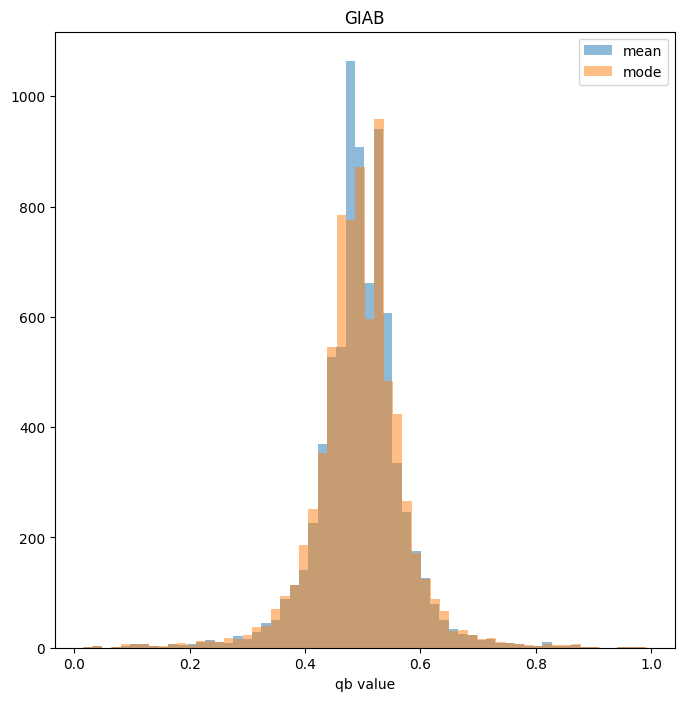

In [15]:
plt.figure(figsize=(8, 8)) 
plt.hist(GIAB["qb_mean"],bins=60,alpha=0.5,label="mean")
plt.hist(GIAB["qb_mode"],bins=60,alpha=0.5,label="mode")
plt.xlabel("qb value")
plt.title("GIAB")
plt.legend()
plt.show()

In [24]:
mode_ns_ms, mode_ns_Notms, mode_ms_Notns, Notmode_ms_ns, mode_not_ns, ns_not_mode, ms_not_mode, only_qb, only_ns, only_ms = compare_mean_mode(GIAB)

Comparison Table:
       Method  #ASE gene  Total #gene  ASE Percentage
0    Mode st       1008         7628       13.214473
1   NaiveSum        842         7628       11.038280
2  MajorSite        577         7628        7.564237


In [27]:
only_ns

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,ns_corrected,ms_corrected
602,ENSG00000118193,0.560011,0.000494,0.560645,8,536,0.011152,0.002824,0.004354,0.038472,0.347988,67.0,0.347988,0.075260,0.041294,0.258205
1139,ENSG00000179532,0.558881,0.000442,0.560035,23,690,0.011024,0.000142,0.001379,0.135385,0.341376,30.0,0.341376,0.074488,0.016509,0.538815
1468,ENSG00000188486,0.439402,0.000482,0.439286,3,546,0.006942,0.002635,0.005359,0.012032,-0.351425,182.0,0.351425,0.051868,0.048842,0.118425
1817,ENSG00000057704,0.457740,0.000263,0.457174,6,1152,0.009306,0.002763,0.003518,0.272630,-0.244454,192.0,0.244454,0.065247,0.035082,0.765129
1921,ENSG00000157782,0.642806,0.002740,0.646843,6,66,0.009806,0.003529,0.003545,0.034690,0.847676,11.0,0.847676,0.067875,0.035254,0.241435
1956,ENSG00000111364,0.449796,0.000420,0.448909,6,720,0.019685,0.008808,0.005278,0.600740,-0.290698,120.0,0.290698,0.113155,0.048452,1.000000
2128,ENSG00000134905,0.556563,0.000431,0.556736,6,594,0.013597,0.004898,0.004668,0.010045,0.327814,99.0,0.327814,0.087231,0.043367,0.105834
2265,ENSG00000125952,0.463811,0.000187,0.463717,7,1568,0.007219,0.001404,0.004034,0.021504,-0.209203,224.0,0.209203,0.053722,0.038854,0.177139
2509,ENSG00000185088,0.407775,0.004374,0.390216,10,170,0.009860,0.007514,0.002129,1.000000,-0.538373,17.0,0.538373,0.068190,0.022876,1.000000
2783,ENSG00000011638,0.425890,0.000604,0.425514,3,405,0.007324,0.003841,0.002080,0.035025,-0.430846,135.0,0.430846,0.054133,0.022472,0.242527


In [28]:
only_ms

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,ns_corrected,ms_corrected
329,ENSG00000117569,0.601436,0.002175,0.602550,4,128,0.011952,0.004727,0.052324,0.001824,0.593598,32.0,0.593598,0.079069,0.263881,0.029169
741,ENSG00000162885,0.609437,0.002385,0.614021,6,108,0.009773,0.004375,0.072126,0.003183,0.641920,18.0,0.641920,0.067708,0.317723,0.043513
781,ENSG00000170525,0.477397,0.000248,0.478648,6,1452,0.127442,0.059399,0.121765,0.002130,-0.130527,242.0,0.130527,0.380927,0.446285,0.032492
1296,ENSG00000014216,0.564608,0.000599,0.564938,2,412,0.006719,0.005651,0.007804,0.002914,0.374935,206.0,0.374935,0.050707,0.065201,0.041073
1372,ENSG00000149257,0.526244,0.000295,0.529416,9,1404,0.043317,0.030449,0.394280,0.002835,0.151590,156.0,0.151590,0.189573,0.842455,0.040200
1438,ENSG00000150768,0.469121,0.000179,0.469128,5,1690,0.018120,0.008523,0.014999,0.000658,-0.178421,338.0,0.178421,0.106650,0.112393,0.012513
1887,ENSG00000111252,0.438039,0.000865,0.437738,2,278,0.021960,0.019431,0.035613,0.001888,-0.359410,139.0,0.359410,0.121824,0.202579,0.029813
1974,ENSG00000198598,0.644742,0.009131,0.649807,3,12,0.012154,0.006728,0.092285,0.001953,0.859853,4.0,0.859853,0.079834,0.372264,0.030281
2251,ENSG00000100592,0.584859,0.001950,0.594152,4,184,0.014684,0.016353,0.161122,0.002929,0.494485,46.0,0.494485,0.091964,0.522107,0.041073
2315,ENSG00000009830,0.406244,0.001757,0.404477,7,119,0.027566,0.008798,0.019677,0.001065,-0.547526,17.0,0.547526,0.141428,0.135346,0.018762


In [26]:
ms_not_mode

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,ns_corrected,ms_corrected
329,ENSG00000117569,0.601436,0.002175,0.602550,4,128,0.011952,0.004727,0.052324,0.001824,0.593598,32.0,0.593598,0.079069,0.263881,0.029169
741,ENSG00000162885,0.609437,0.002385,0.614021,6,108,0.009773,0.004375,0.072126,0.003183,0.641920,18.0,0.641920,0.067708,0.317723,0.043513
781,ENSG00000170525,0.477397,0.000248,0.478648,6,1452,0.127442,0.059399,0.121765,0.002130,-0.130527,242.0,0.130527,0.380927,0.446285,0.032492
1296,ENSG00000014216,0.564608,0.000599,0.564938,2,412,0.006719,0.005651,0.007804,0.002914,0.374935,206.0,0.374935,0.050707,0.065201,0.041073
1372,ENSG00000149257,0.526244,0.000295,0.529416,9,1404,0.043317,0.030449,0.394280,0.002835,0.151590,156.0,0.151590,0.189573,0.842455,0.040200
1438,ENSG00000150768,0.469121,0.000179,0.469128,5,1690,0.018120,0.008523,0.014999,0.000658,-0.178421,338.0,0.178421,0.106650,0.112393,0.012513
1887,ENSG00000111252,0.438039,0.000865,0.437738,2,278,0.021960,0.019431,0.035613,0.001888,-0.359410,139.0,0.359410,0.121824,0.202579,0.029813
1974,ENSG00000198598,0.644742,0.009131,0.649807,3,12,0.012154,0.006728,0.092285,0.001953,0.859853,4.0,0.859853,0.079834,0.372264,0.030281
2251,ENSG00000100592,0.584859,0.001950,0.594152,4,184,0.014684,0.016353,0.161122,0.002929,0.494485,46.0,0.494485,0.091964,0.522107,0.041073
2291,ENSG00000119599,0.437554,0.000427,0.437174,6,600,0.007287,0.002995,0.001707,0.000486,-0.362253,100.0,0.362253,0.054060,0.019266,0.009725


In [18]:
only_qb

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,ns_corrected,ms_corrected
62,ENSG00000215910,0.359371,0.009161,0.346232,2,6,0.006367,5.686303e-03,0.015625,0.062500,-0.834015,3.0,0.834015,0.048520,0.114086,0.346727
138,ENSG00000130770,0.574165,0.000332,0.574659,2,822,0.000014,7.910071e-06,0.485728,0.040453,0.431173,411.0,0.431173,0.000299,0.909494,0.262619
142,ENSG00000180098,0.357604,0.009006,0.344984,1,7,0.005319,5.320980e-03,0.015625,0.015625,-0.845103,7.0,0.845103,0.042409,0.114086,0.143082
196,ENSG00000084072,0.435077,0.000189,0.434912,10,1540,0.000008,4.422548e-09,0.059879,0.397134,-0.376783,154.0,0.376783,0.000184,0.290375,0.913552
428,ENSG00000213190,0.383849,0.001744,0.375281,3,177,0.001305,1.200479e-03,0.070938,0.019827,-0.682743,59.0,0.682743,0.014289,0.314786,0.170571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7562,ENSG00000148343,0.604321,0.001624,0.605733,1,131,0.006013,5.987881e-03,0.008511,0.008511,0.610987,131.0,0.610987,0.046614,0.069737,0.093015
7564,ENSG00000136816,0.447416,0.005788,0.402838,3,348,0.000154,3.009305e-02,0.013689,0.378537,-0.304578,116.0,0.304578,0.002517,0.104109,0.895620
7568,ENSG00000187239,0.472391,0.000132,0.471126,7,4641,0.000559,3.215983e-04,0.283968,0.588021,-0.159486,663.0,0.159486,0.007202,0.713134,1.000000
7578,ENSG00000130723,0.548106,0.000533,0.552512,7,1204,0.000429,2.456414e-04,0.134102,0.549689,0.278471,172.0,0.278471,0.005772,0.466877,1.000000


In [20]:
only_ns.shape

(29, 16)

In [22]:
only_ns.shape

(29, 16)

In [9]:
mode_ns_ms

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,ns_corrected,ms_corrected
17,ENSG00000157916,0.607046,0.000865,0.607811,4,264,1.617728e-04,4.636261e-05,2.273474e-04,3.125611e-03,0.627448,66.0,0.627448,2.625539e-03,3.605418e-03,4.300565e-02
63,ENSG00000177000,0.619572,0.000397,0.619896,12,612,7.233369e-07,1.351206e-09,1.100000e-09,3.293880e-05,0.703647,51.0,0.703647,1.984753e-05,4.487059e-08,9.201985e-04
105,ENSG00000090686,0.713560,0.002803,0.719608,1,55,6.230328e-05,6.180727e-05,3.305380e-05,3.305380e-05,1.316800,55.0,1.316800,1.136960e-03,6.554295e-04,9.201985e-04
123,ENSG00000130695,0.403331,0.000709,0.402723,2,334,2.318251e-04,1.032849e-04,2.354167e-04,2.350180e-05,-0.564967,167.0,0.564967,3.515630e-03,3.725640e-03,6.868649e-04
125,ENSG00000169442,0.602337,0.000179,0.602607,1,1541,2.792033e-17,3.132596e-17,0.000000e+00,0.000000e+00,0.599025,1541.0,0.599025,2.878058e-15,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7532,ENSG00000148175,0.841918,0.001786,0.851333,1,57,1.444796e-10,1.481818e-10,0.000000e+00,0.000000e+00,2.413007,57.0,2.413007,6.370463e-09,0.000000e+00,0.000000e+00
7591,ENSG00000148288,0.725777,0.001676,0.729600,2,102,4.844686e-08,1.715190e-08,7.680000e-08,5.870000e-08,1.404174,51.0,1.404174,1.620845e-06,2.503549e-06,2.633904e-06
7604,ENSG00000187796,0.177910,0.000990,0.173664,4,132,1.279749e-16,5.456267e-20,2.056600e-06,1.570000e-08,-2.208144,33.0,2.208144,1.284464e-14,5.314430e-05,7.775639e-07
7620,ENSG00000180549,0.176138,0.002590,0.164040,2,38,2.135666e-10,2.817200e-10,3.000000e-10,2.161000e-07,-2.225692,19.0,2.225692,9.101039e-09,1.300227e-08,8.958754e-06


In [10]:
mode_ns_Notms

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,ns_corrected,ms_corrected
3,ENSG00000188157,0.446295,0.000194,0.446290,9,1458,0.000227,0.000005,0.000035,0.054509,-0.311122,162.0,0.311122,0.003464,0.000682,0.322072
21,ENSG00000157873,0.539955,0.000131,0.539965,8,2336,0.000218,0.000010,0.000109,0.015036,0.231064,292.0,0.231064,0.003356,0.001883,0.140733
45,ENSG00000049239,0.397353,0.000748,0.396283,17,357,0.001089,0.000022,0.000039,0.331750,-0.600890,21.0,0.600890,0.012348,0.000762,0.842136
91,ENSG00000127481,0.439699,0.000314,0.439528,7,840,0.003870,0.000620,0.000380,0.041352,-0.349686,120.0,0.349686,0.033134,0.005561,0.266558
93,ENSG00000053372,0.469225,0.000078,0.469277,7,4704,0.000396,0.000042,0.000024,0.032232,-0.177819,672.0,0.177819,0.005371,0.000487,0.229779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,ENSG00000106701,0.573345,0.000529,0.573883,7,497,0.003492,0.001078,0.000761,0.199909,0.426333,71.0,0.426333,0.030583,0.010099,0.673844
7501,ENSG00000198121,0.319423,0.001759,0.316344,5,105,0.000110,0.000006,0.000016,0.004551,-1.091287,21.0,1.091287,0.001875,0.000342,0.057223
7611,ENSG00000233016,0.390054,0.000600,0.389462,6,396,0.000142,0.000007,0.000005,0.201473,-0.645008,66.0,0.645008,0.002355,0.000117,0.676722
7626,ENSG00000176101,0.458010,0.000188,0.457923,4,1516,0.002239,0.001446,0.001016,0.045900,-0.242887,379.0,0.242887,0.021920,0.012835,0.286520


In [12]:
mode_ms_Notns.shape

(43, 16)

In [14]:
Notmode_ms_ns.shape

(7, 16)

In [17]:
mean_not_mode

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,mean_st_corrected,ns_corrected,ms_corrected
70,ENSG00000116731,0.544194,0.000323,0.544512,7,854,0.016836,0.004542,0.008610,0.057833,0.255703,122.0,0.255703,0.100802,0.034272,0.070465,0.334714
263,ENSG00000162600,0.429661,0.000748,0.429174,7,322,0.019800,0.007166,0.008711,0.009212,-0.408624,46.0,0.408624,0.113645,0.049649,0.071102,0.098691
306,ENSG00000183291,0.458713,0.000346,0.460979,4,1056,0.014754,0.004343,0.016393,0.015967,-0.238802,264.0,0.238802,0.092037,0.033028,0.118638,0.145693
329,ENSG00000117569,0.601436,0.002175,0.602550,4,128,0.011952,0.004727,0.052324,0.001824,0.593598,32.0,0.593598,0.079069,0.035455,0.263881,0.029169
570,ENSG00000186283,0.453218,0.000343,0.453019,4,768,0.015262,0.006967,0.008478,0.036161,-0.270762,192.0,0.270762,0.093811,0.048443,0.069535,0.247611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7374,ENSG00000137145,0.584675,0.001048,0.585526,4,220,0.010800,0.003966,0.007256,0.031645,0.493393,55.0,0.493393,0.073360,0.030558,0.062473,0.226022
7383,ENSG00000120162,0.362342,0.004086,0.356621,3,39,0.007916,0.005224,0.016589,0.041389,-0.815431,13.0,0.815431,0.057897,0.038689,0.119491,0.266558
7391,ENSG00000137073,0.596546,0.001315,0.597704,5,170,0.010599,0.004417,0.007088,0.067170,0.564231,34.0,0.564231,0.072254,0.033425,0.061373,0.360320
7409,ENSG00000137106,0.610369,0.001473,0.612005,5,145,0.008029,0.002013,0.003054,0.007621,0.647573,29.0,0.647573,0.058550,0.017709,0.031233,0.085863


In [18]:
mode_not_mean

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,mean_st_corrected,ns_corrected,ms_corrected
267,ENSG00000132849,0.419842,0.006647,0.391936,7,154,0.004991,0.011006,0.003693,0.882996,-0.466602,22.0,0.466602,0.040503,0.068986,0.036490,1.000000
665,ENSG00000123684,0.473365,0.003387,0.438963,9,1017,0.001032,0.077968,0.000089,0.948973,-0.153848,113.0,0.153848,0.011806,0.274452,0.001555,1.000000
704,ENSG00000143776,0.546222,0.022534,0.692800,6,30,0.000516,0.329843,0.162756,0.226562,0.267503,5.0,0.267503,0.006779,0.564924,0.524725,0.710616
980,ENSG00000155256,0.533550,0.003321,0.570792,6,558,0.001288,0.067835,0.035003,0.875581,0.193902,93.0,0.193902,0.014152,0.249028,0.200475,1.000000
1593,ENSG00000171681,0.542714,0.000874,0.554325,3,717,0.005771,0.019453,0.910866,0.061515,0.247097,239.0,0.247097,0.045119,0.105466,1.000000,0.346727
1879,ENSG00000196510,0.564486,0.014870,0.662653,4,28,0.005260,0.239277,0.584665,0.179565,0.374216,7.0,0.374216,0.042327,0.528988,0.982556,0.626729
2601,ENSG00000170776,0.463585,0.000584,0.457450,30,3480,0.000204,0.886977,0.015335,0.496861,-0.210516,116.0,0.210516,0.003185,0.963386,0.114086,0.958099
2610,ENSG00000140525,0.480083,0.000679,0.463368,7,1848,0.004585,0.067804,0.545856,0.331558,-0.114998,264.0,0.114998,0.037732,0.249028,0.951901,0.842136
2978,ENSG00000135686,0.481981,0.003390,0.437957,24,1824,0.000011,0.070707,0.021187,0.703139,-0.104028,76.0,0.104028,0.000235,0.255618,0.142263,1.000000
3269,ENSG00000259207,0.547101,0.001474,0.565952,3,750,0.000821,0.008476,0.583912,0.179313,0.272620,250.0,0.272620,0.009765,0.056663,0.982556,0.626729


In [7]:
mode_not_ns

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,mean_st_corrected,ns_corrected,ms_corrected
62,ENSG00000215910,0.359371,0.009161,0.346232,2,6,0.006367,5.686303e-03,0.015625,0.062500,-0.834015,3.0,0.834015,0.048520,4.107492e-02,0.114086,0.346727
138,ENSG00000130770,0.574165,0.000332,0.574659,2,822,0.000014,7.910071e-06,0.485728,0.040453,0.431173,411.0,0.431173,0.000299,1.475257e-04,0.909494,0.262619
142,ENSG00000180098,0.357604,0.009006,0.344984,1,7,0.005319,5.320980e-03,0.015625,0.015625,-0.845103,7.0,0.845103,0.042409,3.906694e-02,0.114086,0.143082
196,ENSG00000084072,0.435077,0.000189,0.434912,10,1540,0.000008,4.422548e-09,0.059879,0.397134,-0.376783,154.0,0.376783,0.000184,1.405633e-07,0.290375,0.913552
428,ENSG00000213190,0.383849,0.001744,0.375281,3,177,0.001305,1.200479e-03,0.070938,0.019827,-0.682743,59.0,0.682743,0.014289,1.162088e-02,0.314786,0.170571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7564,ENSG00000136816,0.447416,0.005788,0.402838,3,348,0.000154,3.009305e-02,0.013689,0.378537,-0.304578,116.0,0.304578,0.002517,1.447058e-01,0.104109,0.895620
7568,ENSG00000187239,0.472391,0.000132,0.471126,7,4641,0.000559,3.215983e-04,0.283968,0.588021,-0.159486,663.0,0.159486,0.007202,3.815166e-03,0.713134,1.000000
7578,ENSG00000130723,0.548106,0.000533,0.552512,7,1204,0.000429,2.456414e-04,0.134102,0.549689,0.278471,172.0,0.278471,0.005772,3.081830e-03,0.466877,1.000000
7597,ENSG00000196363,0.433706,0.000905,0.427730,4,640,0.000321,4.176021e-04,0.033128,0.900362,-0.384831,160.0,0.384831,0.004528,4.811887e-03,0.193585,1.000000


In [10]:
ns_not_mode.shape

(36, 17)

### highlight the points in the scatter plot based on whether the genes are significant in 'mean' but not in 'mode', and vice versa, 

In [23]:
df=GIAB
alpha = 0.05

In [24]:
df

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,mean_st_corrected,ns_corrected,ms_corrected
0,ENSG00000187583,0.522732,0.009866,0.524547,2,6,0.667026,0.658238,1.000000,0.625000,0.131270,3.0,0.131270,0.827180,0.819095,1.000000,1.000000
1,ENSG00000188290,0.566433,0.010440,0.572869,1,5,0.199718,0.199661,0.375000,0.375000,0.385649,5.0,0.385649,0.477075,0.470357,0.825303,0.891399
2,ENSG00000187608,0.517959,0.000102,0.517992,1,3212,0.047966,0.049021,0.042428,0.042428,0.103682,3212.0,0.103682,0.204406,0.197639,0.227917,0.271285
3,ENSG00000188157,0.446295,0.000194,0.446290,9,1458,0.000227,0.000005,0.000035,0.054509,-0.311122,162.0,0.311122,0.003464,0.000106,0.000682,0.322072
4,ENSG00000237330,0.472755,0.011704,0.470077,2,2,0.400358,0.392479,1.000000,0.500000,-0.157382,1.0,0.157382,0.640103,0.629220,1.000000,0.958099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7631,ENSG00000198113,0.523703,0.001401,0.525157,2,176,0.437607,0.447622,0.497629,1.000000,0.136885,88.0,0.136885,0.675318,0.680849,0.909494,1.000000
7632,ENSG00000187609,0.555929,0.003908,0.557681,1,45,0.294917,0.294207,0.371298,0.371298,0.324111,45.0,0.324111,0.554893,0.550852,0.825303,0.891399
7633,ENSG00000165802,0.601217,0.006764,0.607419,1,17,0.096331,0.096301,0.143463,0.143463,0.592281,17.0,0.592281,0.317139,0.308779,0.485500,0.557766
7634,ENSG00000197070,0.449680,0.001598,0.448064,2,146,0.159917,0.151145,0.186765,0.505236,-0.291371,73.0,0.291371,0.431958,0.408842,0.567588,0.958099


### plot1

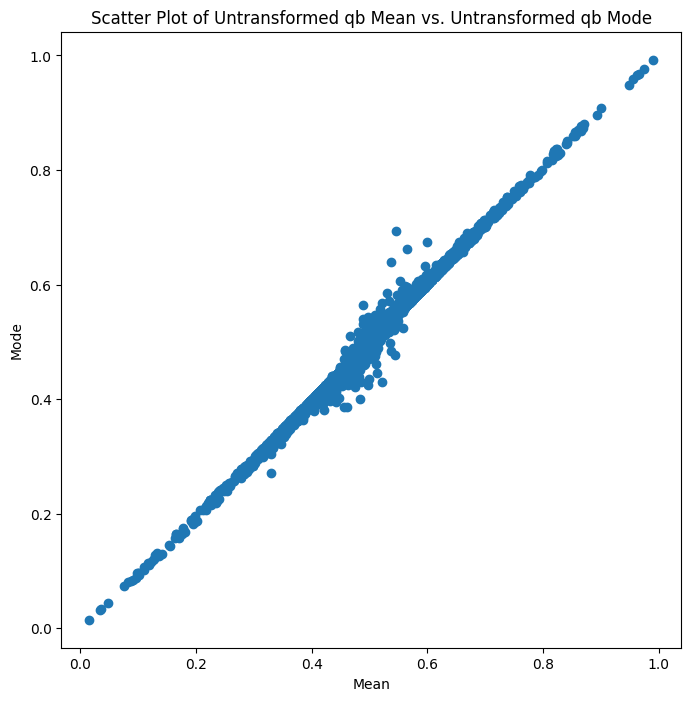

In [25]:
plt.figure(figsize=(8, 8)) 
plt.scatter(GIAB["qb_mean"],GIAB["qb_mode"])
plt.xlabel("Mean")
plt.ylabel("Mode")
plt.title('Scatter Plot of Untransformed qb Mean vs. Untransformed qb Mode')
plt.show()

### plot2

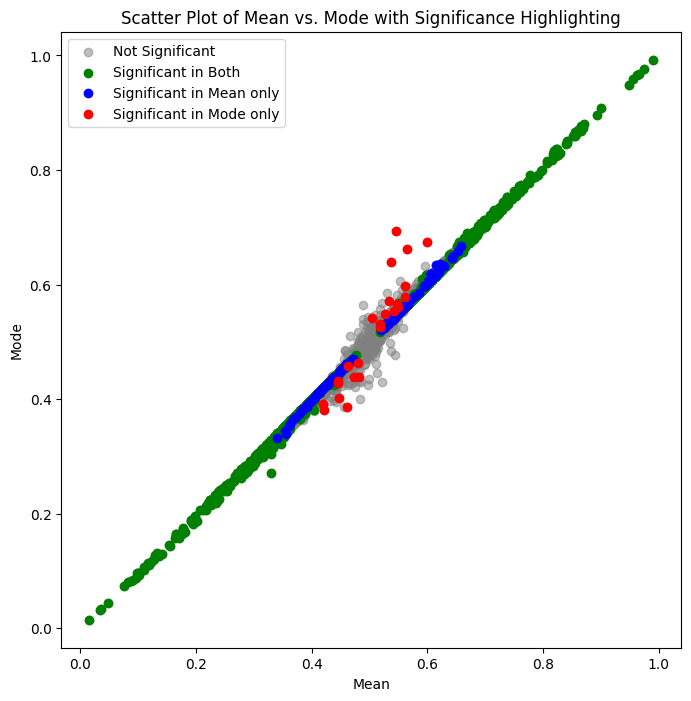

In [26]:
# Conditions for significance

mean_not_mode = (df['mean_st_corrected'] < alpha) & (df['mode_st_corrected'] >= alpha)
mode_not_mean = (df['mode_st_corrected'] < alpha) & (df['mean_st_corrected'] >= alpha)
both_significant = (df['mean_st_corrected'] < alpha) & (df['mode_st_corrected'] < alpha)

# Creating the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.scatter(df['qb_mean'], df['qb_mode'], color='gray', alpha=0.5, label='Not Significant')  # All points in gray
plt.scatter(df.loc[both_significant, 'qb_mean'], df.loc[both_significant, 'qb_mode'], color='green', label='Significant in Both')
plt.scatter(df.loc[mean_not_mode, 'qb_mean'], df.loc[mean_not_mode, 'qb_mode'], color='blue', label='Significant in Mean only')
plt.scatter(df.loc[mode_not_mean, 'qb_mean'], df.loc[mode_not_mean, 'qb_mode'], color='red', label='Significant in Mode only')

# Adding labels and title for clarity
plt.xlabel('Mean')
plt.ylabel('Mode')
plt.title('Scatter Plot of Mean vs. Mode with Significance Highlighting')
plt.legend()
# Show the plot
plt.show()

## plot3

In [27]:
df.head()

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,mean_st_corrected,ns_corrected,ms_corrected
0,ENSG00000187583,0.522732,0.009866,0.524547,2,6,0.667026,0.658238,1.000000,0.625000,0.131270,3.0,0.131270,0.827180,0.819095,1.000000,1.000000
1,ENSG00000188290,0.566433,0.010440,0.572869,1,5,0.199718,0.199661,0.375000,0.375000,0.385649,5.0,0.385649,0.477075,0.470357,0.825303,0.891399
2,ENSG00000187608,0.517959,0.000102,0.517992,1,3212,0.047966,0.049021,0.042428,0.042428,0.103682,3212.0,0.103682,0.204406,0.197639,0.227917,0.271285
3,ENSG00000188157,0.446295,0.000194,0.446290,9,1458,0.000227,0.000005,0.000035,0.054509,-0.311122,162.0,0.311122,0.003464,0.000106,0.000682,0.322072
4,ENSG00000237330,0.472755,0.011704,0.470077,2,2,0.400358,0.392479,1.000000,0.500000,-0.157382,1.0,0.157382,0.640103,0.629220,1.000000,0.958099


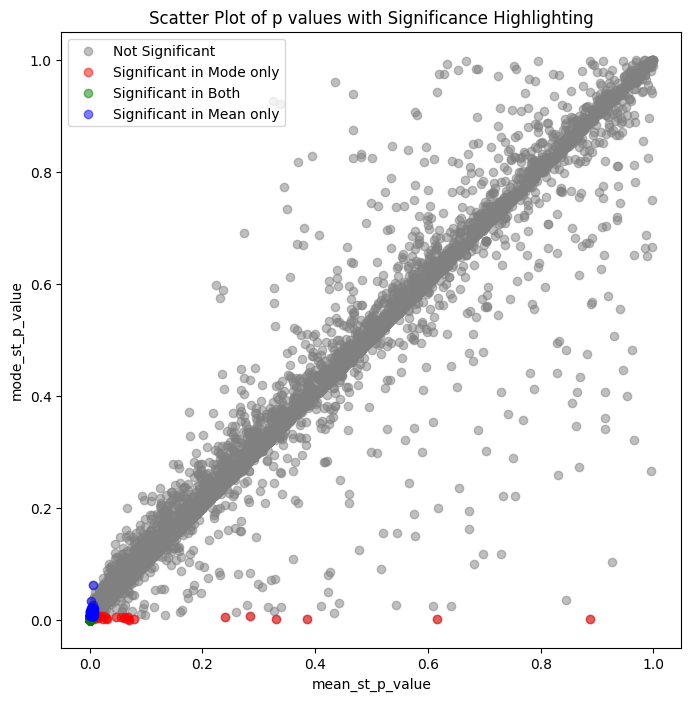

In [28]:
# Conditions for significance
df = GIAB

mean_not_mode = (df['mean_st_corrected'] < alpha) & (df['mode_st_corrected'] >= alpha)
mode_not_mean = (df['mode_st_corrected'] < alpha) & (df['mean_st_corrected'] >= alpha)
both_significant = (df['mean_st_corrected'] < alpha) & (df['mode_st_corrected'] < alpha)

# Creating the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.scatter(df['mean_st_p_value'], df['mode_st_p_value'], color='gray', alpha=0.5, label='Not Significant')  # All points in gray
plt.scatter(df.loc[mode_not_mean, 'mean_st_p_value'], df.loc[mode_not_mean, 'mode_st_p_value'], alpha=0.5,color='red', label='Significant in Mode only')
plt.scatter(df.loc[both_significant, 'mean_st_p_value'], df.loc[both_significant, 'mode_st_p_value'], alpha=0.5,color='green', label='Significant in Both')
plt.scatter(df.loc[mean_not_mode, 'mean_st_p_value'], df.loc[mean_not_mode, 'mode_st_p_value'], alpha=0.5,color='blue', label='Significant in Mean only')

# Adding labels and title for clarity
plt.xlabel('mean_st_p_value')
plt.ylabel('mode_st_p_value')
plt.title('Scatter Plot of p values with Significance Highlighting')
plt.legend()
# Show the plot
plt.show()

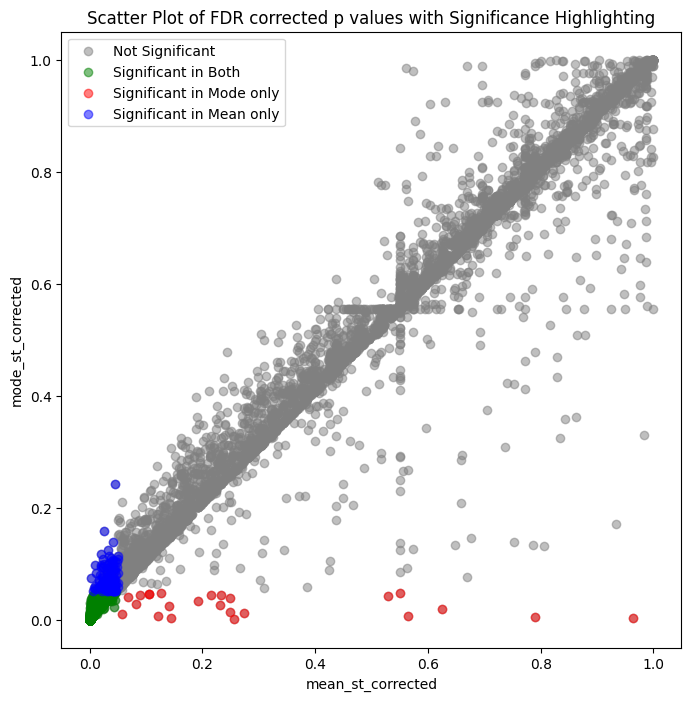

In [29]:
# Conditions for significance
df = GIAB

mean_not_mode = (df['mean_st_corrected'] < alpha) & (df['mode_st_corrected'] >= alpha)
mode_not_mean = (df['mode_st_corrected'] < alpha) & (df['mean_st_corrected'] >= alpha)
both_significant = (df['mean_st_corrected'] < alpha) & (df['mode_st_corrected'] < alpha)

# Creating the scatter plot
plt.figure(figsize=(8, 8))  # Adjust the figure size as needed
plt.scatter(df['mean_st_corrected'], df['mode_st_corrected'], color='gray', alpha=0.5, label='Not Significant')  # All points in gray
plt.scatter(df.loc[both_significant, 'mean_st_corrected'], df.loc[both_significant, 'mode_st_corrected'], alpha=0.5,color='green', label='Significant in Both')
plt.scatter(df.loc[mode_not_mean, 'mean_st_corrected'], df.loc[mode_not_mean, 'mode_st_corrected'], alpha=0.5,color='red', label='Significant in Mode only')
plt.scatter(df.loc[mean_not_mode, 'mean_st_corrected'], df.loc[mean_not_mode, 'mode_st_corrected'], alpha=0.5,color='blue', label='Significant in Mean only')

# Adding labels and title for clarity
plt.xlabel('mean_st_corrected')
plt.ylabel('mode_st_corrected')
plt.title('Scatter Plot of FDR corrected p values with Significance Highlighting')
plt.legend()
# Show the plot
plt.show()

In [30]:
mode_only = df.loc[mode_not_mean]
mean_only = df.loc[mean_not_mode]

In [31]:

mode_only.sort_values(by=['mode_st_p_value','mean_st_p_value'], ascending=[True,False]).head(n=20)


,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,mean_st_corrected,ns_corrected,ms_corrected
2978,ENSG00000135686,0.481981,0.003390,0.437957,24,1824,0.000011,0.070707,0.021187,0.703139,-0.104028,76.0,0.104028,0.000235,0.255618,0.142263,1.000000
7564,ENSG00000136816,0.447416,0.005788,0.402838,3,348,0.000154,0.030093,0.013689,0.378537,-0.304578,116.0,0.304578,0.002517,0.144706,0.104109,0.895620
2601,ENSG00000170776,0.463585,0.000584,0.457450,30,3480,0.000204,0.886977,0.015335,0.496861,-0.210516,116.0,0.210516,0.003185,0.963386,0.114086,0.958099
3842,ENSG00000099331,0.504233,0.001596,0.541824,9,2997,0.000355,0.616741,0.079584,0.498249,0.024426,333.0,0.024426,0.004926,0.790411,0.337446,0.958099
5218,ENSG00000235568,0.599103,0.016626,0.673837,3,87,0.000464,0.023814,0.024623,0.281042,0.579574,29.0,0.579574,0.006167,0.121752,0.157865,0.776734
704,ENSG00000143776,0.546222,0.022534,0.692800,6,30,0.000516,0.329843,0.162756,0.226562,0.267503,5.0,0.267503,0.006779,0.564924,0.524725,0.710616
3269,ENSG00000259207,0.547101,0.001474,0.565952,3,750,0.000821,0.008476,0.583912,0.179313,0.272620,250.0,0.272620,0.009765,0.056663,0.982556,0.626729
665,ENSG00000123684,0.473365,0.003387,0.438963,9,1017,0.001032,0.077968,0.000089,0.948973,-0.153848,113.0,0.153848,0.011806,0.274452,0.001555,1.000000
980,ENSG00000155256,0.533550,0.003321,0.570792,6,558,0.001288,0.067835,0.035003,0.875581,0.193902,93.0,0.193902,0.014152,0.249028,0.200475,1.000000
3887,ENSG00000064547,0.537419,0.013436,0.640150,2,94,0.001878,0.386410,0.100173,0.391603,0.216342,47.0,0.216342,0.019081,0.625077,0.396329,0.903554


In [32]:
mean_only.sort_values(by=['mean_st_p_value','mode_st_p_value'], ascending=[True,False]).head(n=20)

,geneID,qb_mean,qb_var,qb_mode,n_hets,total_count,mode_st_p_value,mean_st_p_value,NaiveSum_pval,MajorSite_pval,log2_theta,average_readepth,abs_log2_theta,mode_st_corrected,mean_st_corrected,ns_corrected,ms_corrected
1139,ENSG00000179532,0.558881,0.000442,0.560035,23,690,0.011024,0.000142,0.001379,0.135385,0.341376,30.0,0.341376,0.074488,0.001947,0.016509,0.538815
2969,ENSG00000197943,0.524113,0.000092,0.524443,12,4680,0.006700,0.000486,0.000966,0.248917,0.139260,390.0,0.139260,0.050652,0.005423,0.012341,0.727585
6721,ENSG00000106012,0.427861,0.000660,0.426371,14,448,0.007637,0.000678,0.001270,0.203117,-0.419222,32.0,0.419222,0.056180,0.007253,0.015355,0.679550
610,ENSG00000159176,0.446628,0.000404,0.445883,14,742,0.015970,0.000864,0.030917,0.012869,-0.309177,53.0,0.309177,0.097154,0.008816,0.185074,0.125373
4717,ENSG00000130414,0.541776,0.000202,0.541789,10,1410,0.008249,0.001036,0.001724,0.000752,0.241645,141.0,0.241645,0.059697,0.010339,0.019421,0.014065
2290,ENSG00000205683,0.600791,0.002865,0.606301,9,162,0.007293,0.001042,0.052006,0.211609,0.589721,18.0,0.589721,0.054060,0.010360,0.263238,0.690989
5696,ENSG00000178950,0.457666,0.000221,0.457243,15,1335,0.012747,0.001219,0.001644,0.020493,-0.244888,89.0,0.244888,0.082612,0.011773,0.018706,0.173399
2265,ENSG00000125952,0.463811,0.000187,0.463717,7,1568,0.007219,0.001404,0.004034,0.021504,-0.209203,224.0,0.209203,0.053722,0.013208,0.038854,0.177139
4751,ENSG00000125834,0.541946,0.000224,0.542365,10,1420,0.009675,0.001834,0.001592,0.067971,0.242632,142.0,0.242632,0.067214,0.016305,0.018344,0.363084
3608,ENSG00000197971,0.452728,0.000271,0.452547,11,1012,0.010259,0.001834,0.002593,0.150911,-0.273613,92.0,0.273613,0.070563,0.016305,0.026982,0.572143


/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

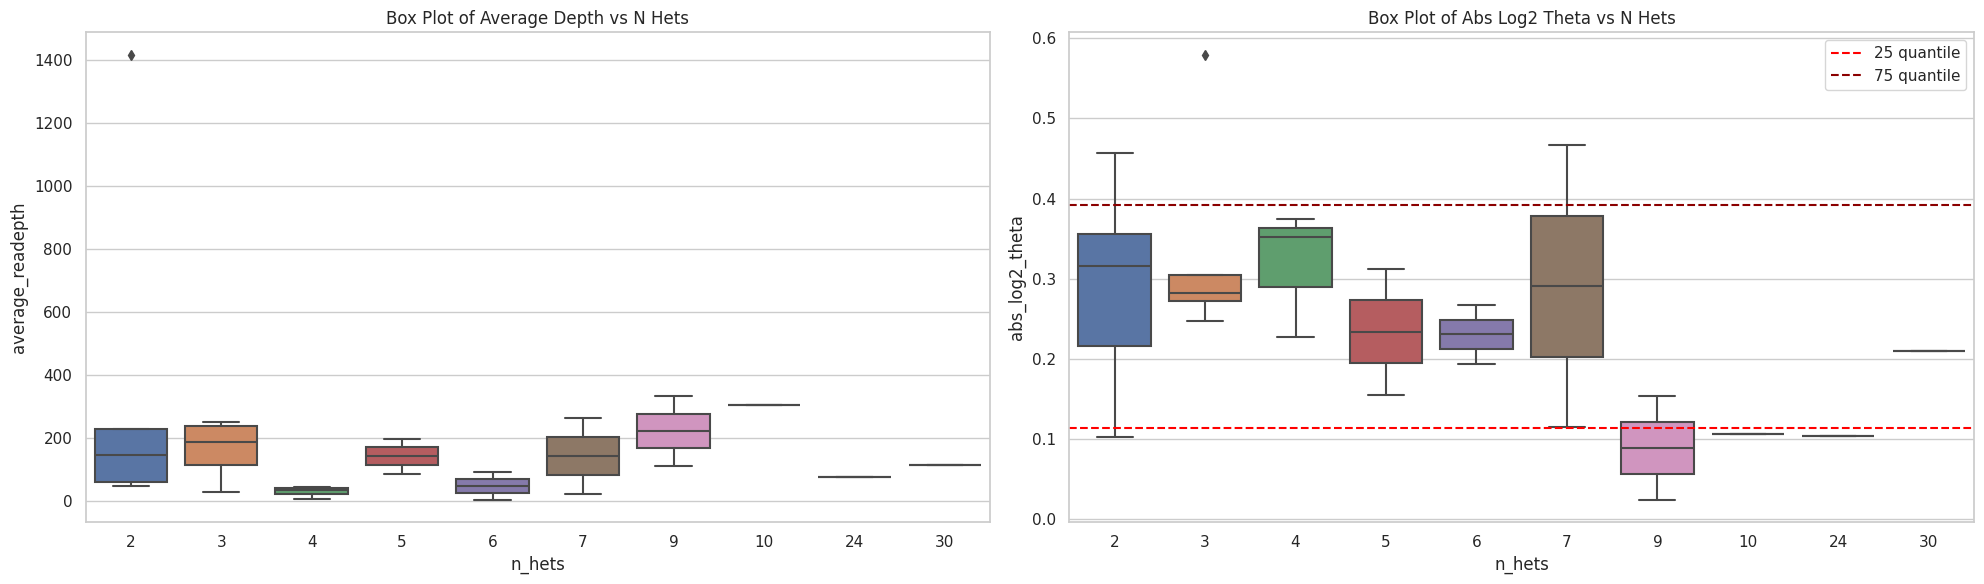

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = GIAB
mode_only_ASE = df.loc[mode_not_mean]


# Setting the style for seaborn plots
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Creating the first boxplot: n_hets vs. average_depth on the first subplot
sns.boxplot(x='n_hets', y='average_readepth', data=mode_only_ASE, ax=axes[0])
axes[0].set_title('Box Plot of Average Depth vs N Hets')

# Creating the second boxplot: n_hets vs. abs_log2_theta on the second subplot
sns.boxplot(x='n_hets', y='abs_log2_theta', data=mode_only_ASE, ax=axes[1])
# plot the horizontal line for the 25 and 75 quantile
axes[1].axhline(y=Q1, color='red', linestyle='dashed',label="25 quantile")
axes[1].axhline(y=Q3, color='darkred', linestyle='dashed',label="75 quantile")
axes[1].legend()
axes[1].set_title('Box Plot of Abs Log2 Theta vs N Hets')

# Display the plots
plt.tight_layout()
plt.show()


In [34]:
plot_coverage_hets(df,'mean_st_corrected','ns_corrected')

NameError: name 'plot_coverage_hets' is not defined

In [35]:
plot_coverage_hets(df,'mean_st_corrected','ns_corrected')

NameError: name 'plot_coverage_hets' is not defined

In [36]:
# Conditions for significance
df = GIAB

def plot_2_columns(df,significant_col1,significant_col2,col1,col2,type):
    mean_not_ns = (df[significant_col1] < alpha) & (df[significant_col2] >= alpha)
    ns_not_mean = (df[significant_col2] < alpha) & (df[significant_col1] >= alpha)
    both_significant = (df[significant_col1] < alpha) & (df[significant_col2] < alpha)

    # Creating the scatter plot
    plt.figure(figsize=(6, 6))  # Adjust the figure size as needed
    plt.scatter(df[col1], df[col2], color='gray', alpha=0.5, label='Not Significant')  # All points in gray
    plt.scatter(df.loc[ns_not_mean, col1], df.loc[ns_not_mean, col2], alpha=0.5,color='red', label=f'Significant in {significant_col1} only')
    plt.scatter(df.loc[mean_not_ns, col1], df.loc[mean_not_ns, col2], alpha=0.5,color='blue', label=f'Significant in {significant_col2} only')
    plt.scatter(df.loc[both_significant, col1], df.loc[both_significant, col2], alpha=0.5,color='green', label='Significant in Both')
    # Adding labels and title for clarity
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f'Scatter Plot of {type} with Significance Highlighting')
    plt.legend(loc='upper right')
    # Show the plot
    plt.show()

def plot_coverage_hets(df,significant_col1,significant_col2):
    Q1_ASE = df["abs_log2_theta"].quantile(0.25)
    Q3_ASE = df["abs_log2_theta"].quantile(0.75)
    Q1_readepth = df["average_readepth"].quantile(0.25)
    Q3_readepth = df["average_readepth"].quantile(0.75)
    mean_not_ns = (df[significant_col1] < alpha) & (df[significant_col2] >= alpha)
    ns_not_mean = (df[significant_col2] < alpha) & (df[significant_col1] >= alpha)
    both_significant = (df[significant_col1] < alpha) & (df[significant_col2] < alpha)
    # 
    mean_only_ASE = df.loc[mean_not_ns]
    ns_only_ASE = df.loc[ns_not_mean]
    both = df.loc[both_significant]
    # Setting the style for seaborn plots
    sns.set(style="whitegrid")

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

    # Creating the first boxplot: n_hets vs. average_depth on the first subplot
    sns.boxplot(x='n_hets', y='average_readepth', data=mean_only_ASE, ax=axes[0,0])
    axes[0,0].axhline(y=Q1_readepth, color='red', linestyle='dashed',label=f"25 quantile: {Q1_readepth}")
    axes[0,0].axhline(y=Q3_readepth, color='darkred', linestyle='dashed',label=f"75 quantile: {Q3_readepth}")
    axes[0,0].set_title(f'Average Depth vs N Hets: sig in {significant_col1} but not in {significant_col2}')
    axes[0,0].legend()

    # Creating the second boxplot: n_hets vs. abs_log2_theta on the second subplot
    sns.boxplot(x='n_hets', y='abs_log2_theta', data=mean_only_ASE, ax=axes[0,1])
    # plot the horizontal line for the 25 and 75 quantile
    axes[0,1].axhline(y=Q1_ASE, color='red', linestyle='dashed',label=f"25 quantile: {Q1_ASE}")
    axes[0,1].axhline(y=Q3_ASE, color='darkred', linestyle='dashed',label=f"75 quantile: {Q3_ASE}")
    axes[0,1].legend()
    axes[0,1].set_title(f'Abs Log2 Theta vs N Hets: sig in {significant_col1} but not in {significant_col2}')

    # Creating the first boxplot: n_hets vs. average_depth on the first subplot
    sns.boxplot(x='n_hets', y='average_readepth', data=ns_only_ASE, ax=axes[1,0])
    axes[1,0].axhline(y=Q1_readepth, color='red', linestyle='dashed',label=f"25 quantile: {Q1_readepth}")
    axes[1,0].axhline(y=Q3_readepth, color='darkred', linestyle='dashed',label=f"75 quantile: {Q3_readepth}")
    axes[1,0].set_title(f'Average Depth vs N Hets: sig in {significant_col2} but not in {significant_col1}')
    axes[1,0].legend()

    # Creating the second boxplot: n_hets vs. abs_log2_theta on the second subplot
    sns.boxplot(x='n_hets', y='abs_log2_theta', data=ns_only_ASE, ax=axes[1,1])
    # plot the horizontal line for the 25 and 75 quantile
    axes[1,1].axhline(y=Q1_ASE, color='red', linestyle='dashed',label=f"25 quantile: {Q1_ASE}")
    axes[1,1].axhline(y=Q3_ASE, color='darkred', linestyle='dashed',label=f"75 quantile: {Q3_ASE}")
    axes[1,1].legend()
    axes[1,1].set_title(f'Abs Log2 Theta vs N Hets: sig in {significant_col2} but not in {significant_col1}')

    # Creating the first boxplot: n_hets vs. average_depth on the first subplot
    sns.boxplot(x='n_hets', y='average_readepth', data=both, ax=axes[2,0])
    axes[2,0].axhline(y=Q1_readepth, color='red', linestyle='dashed',label=f"25 quantile: {Q1_readepth}")
    axes[2,0].axhline(y=Q3_readepth, color='darkred', linestyle='dashed',label=f"75 quantile: {Q3_readepth}")
    axes[2,0].set_title(f'Average Depth vs N Hets: both')
    axes[2,0].legend()

    # Creating the second boxplot: n_hets vs. abs_log2_theta on the second subplot
    sns.boxplot(x='n_hets', y='abs_log2_theta', data=both, ax=axes[2,1])
    # plot the horizontal line for the 25 and 75 quantile
    axes[2,1].axhline(y=Q1_ASE, color='red', linestyle='dashed',label=f"25 quantile: {Q1_ASE}")
    axes[2,1].axhline(y=Q3_ASE, color='darkred', linestyle='dashed',label=f"75 quantile: {Q3_ASE}")
    axes[2,1].legend()
    axes[2,1].set_title(f'Abs Log2 Theta vs N Hets: both')
    # Display the plots
    plt.tight_layout()
    plt.show()

In [37]:
# Creating categories based on significance
def plot_coverage_hets_group(df,significant_col1,significant_col2,col1,col2):
    Q1_ASE = df["abs_log2_theta"].quantile(0.25)
    Q3_ASE = df["abs_log2_theta"].quantile(0.75)
    Q1_readepth = df["average_readepth"].quantile(0.25)
    Q3_readepth = df["average_readepth"].quantile(0.75)
    # Assigning categories based on significance
    df['Category'] = np.where(
        (df[significant_col1] < alpha) & (df[significant_col2] >= alpha), col1,
        np.where(
            (df[significant_col2] < alpha) & (df[significant_col1] >= alpha), col2,
            np.where(
                (df[significant_col1] < alpha) & (df[significant_col2] < alpha),
                'both significant',
                'neither significant'
            )
        )
    )

    # We'll use seaborn's boxplot to create the boxplot with 2 rows and 1 column format.
    # First, we need to melt the dataframe so we can have 'n_hets' as a single variable with multiple measurements.
    melted_df = df.melt(id_vars=['n_hets', 'Category'], value_vars=['average_readepth', 'abs_log2_theta'],
                        var_name='Measurement', value_name='Value')

    # Set the style for the plots
    sns.set(style="whitegrid")

    # Create a figure with 2 subplots (rows) and 1 column
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), sharex=True)

    # Plotting boxplot for average_readepth
    sns.boxplot(x='n_hets', y='Value', hue='Category', data=melted_df[melted_df['Measurement'] == 'average_readepth'], ax=axes[0])
    axes[0].axhline(y=Q1_readepth, color='red', linestyle='dashed',label=f"25 quantile: {Q1_readepth}")
    axes[0].axhline(y=Q3_readepth, color='darkred', linestyle='dashed',label=f"75 quantile: {Q3_readepth}")
    axes[0].set_title('Average Depth vs N Hets',fontsize=16)
    axes[0].legend(title='Category', loc='upper right',fontsize=15)

    # Plotting boxplot for abs_log2_theta
    sns.boxplot(x='n_hets', y='Value', hue='Category', data=melted_df[melted_df['Measurement'] == 'abs_log2_theta'], ax=axes[1])
    axes[1].set_title('Abs Log2 Theta vs N Hets',fontsize=16)
    axes[1].axhline(y=Q1_ASE, color='red', linestyle='dashed',label=f"25 quantile: {Q1_ASE}")
    axes[1].axhline(y=Q3_ASE, color='darkred', linestyle='dashed',label=f"75 quantile: {Q3_ASE}")
    axes[1].legend(title='Category', loc='upper right',fontsize=15)
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

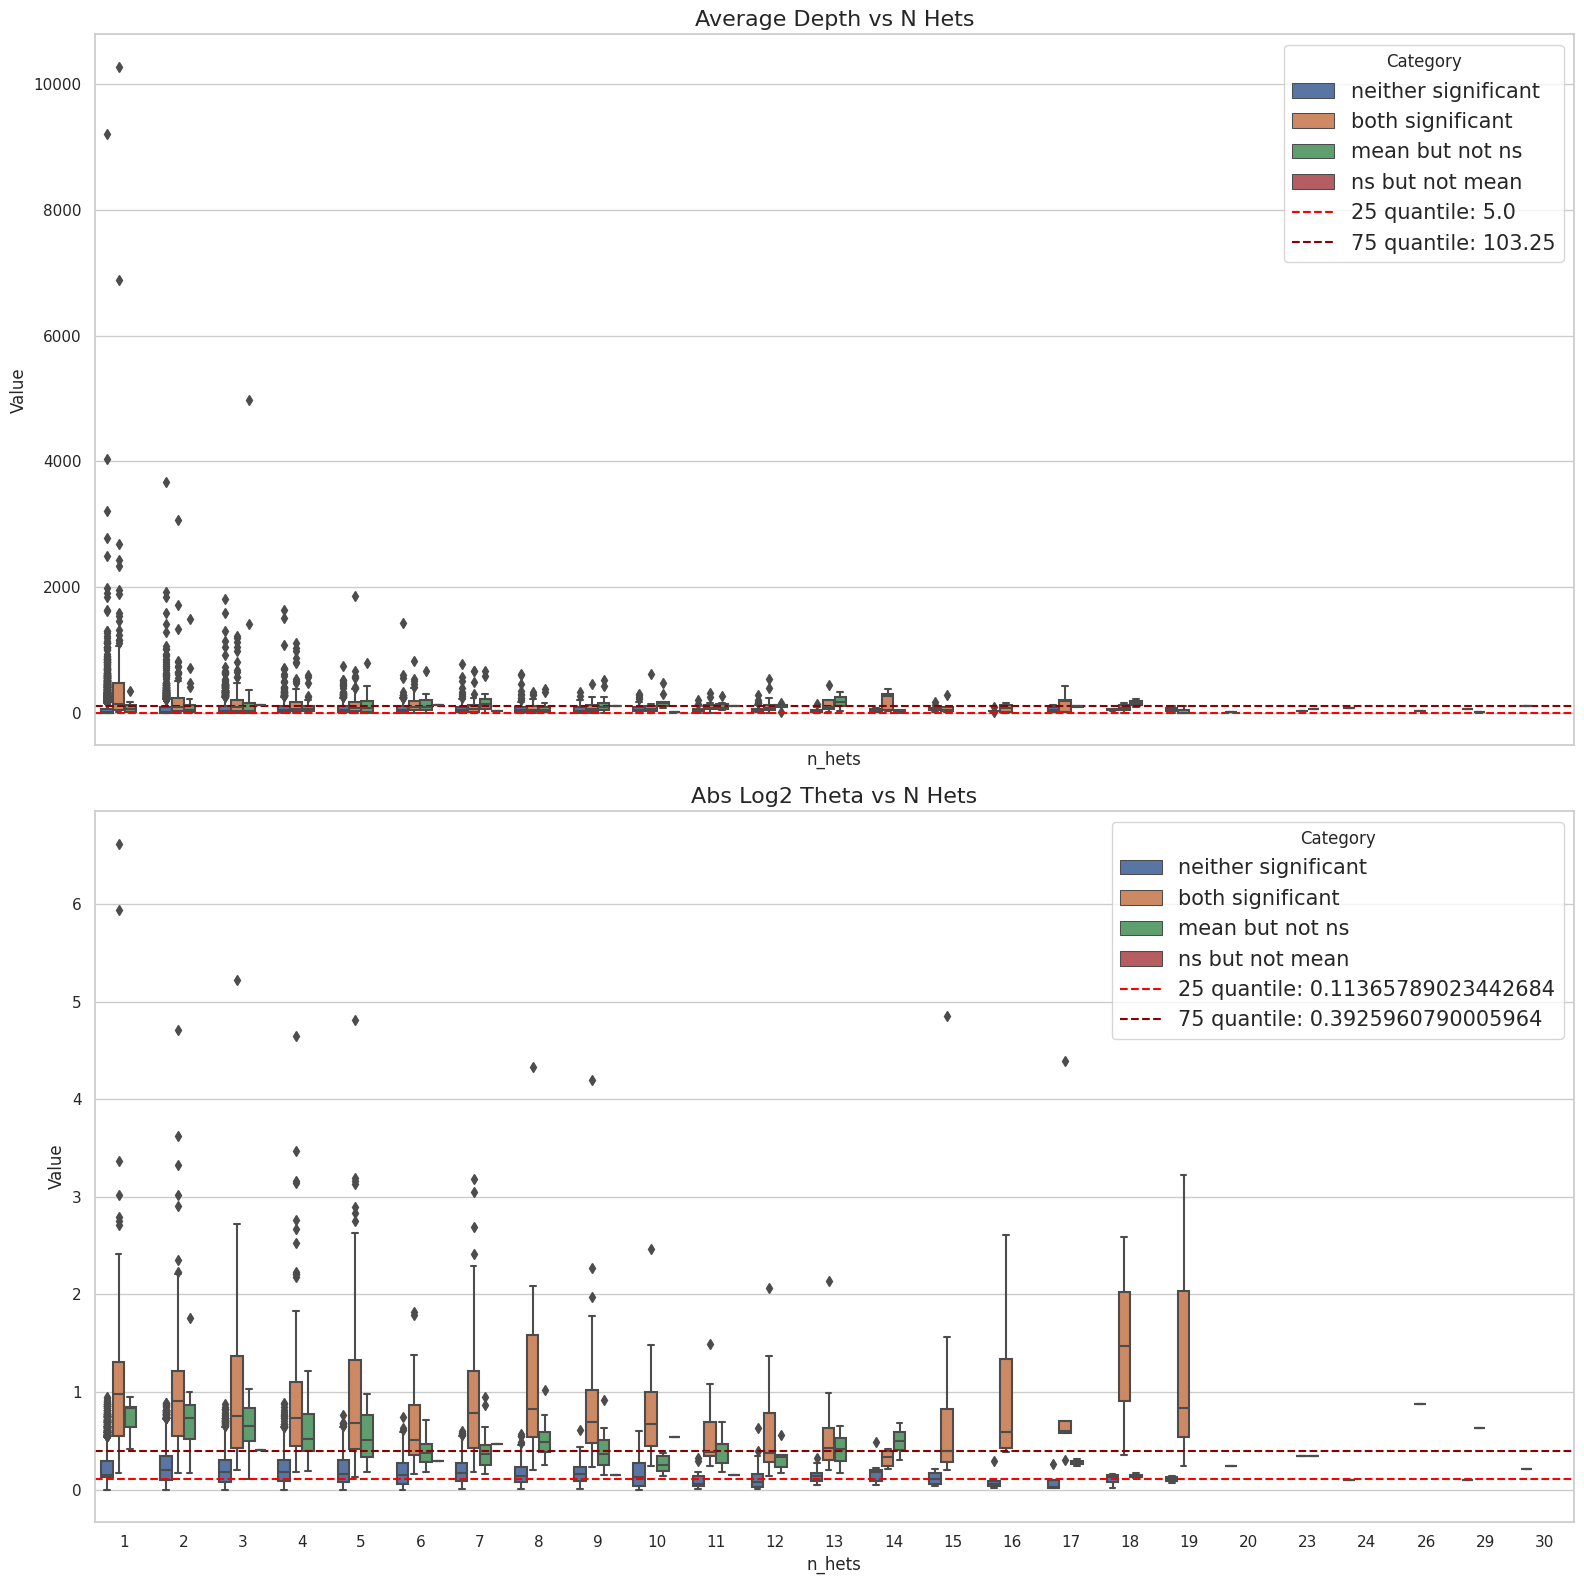

In [38]:
plot_coverage_hets_group(df,'mean_st_corrected','ns_corrected','mean but not ns','ns but not mean')

In [39]:
# Redefine the function to create a 2x4 grid of plots with each column representing a category
def plot_coverage_hets_group_split4(df, significant_col1, significant_col2, col1_label, col2_label):
    # Define the alpha level for significance
    alpha = 0.05
    
    # Quantiles for the dashed lines
    Q1_ASE = df["abs_log2_theta"].quantile(0.25)
    Q3_ASE = df["abs_log2_theta"].quantile(0.75)
    Q1_readepth = df["average_readepth"].quantile(0.25)
    Q3_readepth = df["average_readepth"].quantile(0.75)
    
    # Create the 'Category' column based on the significance test results
    df['Category'] = np.where(
        (df[significant_col1] < alpha) & (df[significant_col2] >= alpha), col1_label,
        np.where(
            (df[significant_col2] < alpha) & (df[significant_col1] >= alpha), col2_label,
            np.where(
                (df[significant_col1] < alpha) & (df[significant_col2] < alpha),
                'both significant',
                'neither significant'
            )
        )
    )
    
    # Melt the dataframe for plotting
    melted_df = df.melt(id_vars=['n_hets', 'Category'], value_vars=['average_readepth', 'abs_log2_theta'],
                        var_name='Measurement', value_name='Value')
    
    # Set the style for the plots
    sns.set(style="whitegrid")

    # Create a figure with 2 rows and 4 columns
    fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True)
    
    # List of unique categories
    categories = df['Category'].unique()
    
    # Loop through each category and create a plot for each
    for i, category in enumerate(categories):
        # Filter the melted dataframe by category
        category_df = melted_df[melted_df['Category'] == category]

        # Boxplot for 'average_readepth' in the first row
        sns.boxplot(x='n_hets', y='Value', data=category_df[category_df['Measurement'] == 'average_readepth'], ax=axes[0, i])
        axes[0, i].axhline(y=Q1_readepth, color='red', linestyle='dashed', label=f"25th quantile: {Q1_readepth}")
        axes[0, i].axhline(y=Q3_readepth, color='darkred', linestyle='dashed', label=f"75th quantile: {Q3_readepth}")
        axes[0, i].set_title(f'{category} (Read Depth)',fontsize=18)

        # Boxplot for 'abs_log2_theta' in the second row
        sns.boxplot(x='n_hets', y='Value', data=category_df[category_df['Measurement'] == 'abs_log2_theta'], ax=axes[1, i])
        axes[1, i].axhline(y=Q1_ASE, color='red', linestyle='dashed', label=f"25th quantile: {Q1_ASE}")
        axes[1, i].axhline(y=Q3_ASE, color='darkred', linestyle='dashed', label=f"75th quantile: {Q3_ASE}")
        axes[1, i].set_title(f'{category} (Abs Log2 Theta)',fontsize=18)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Simulate the dataframe with the necessary structure and call the function
np.random.seed(0)
df_example = pd.DataFrame({
    'n_hets': np.random.choice(range(1, 6), size=100),
    'average_readepth': np.random.choice(range(100, 500), size=100),
    'abs_log2_theta': np.random.normal(0.2, 0.05, size=100),
    'mean_st_corrected': np.random.uniform(0, 0.1, size=100),
    'ns_corrected': np.random.uniform(0, 0.1, size=100)
})


/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/scarlett/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

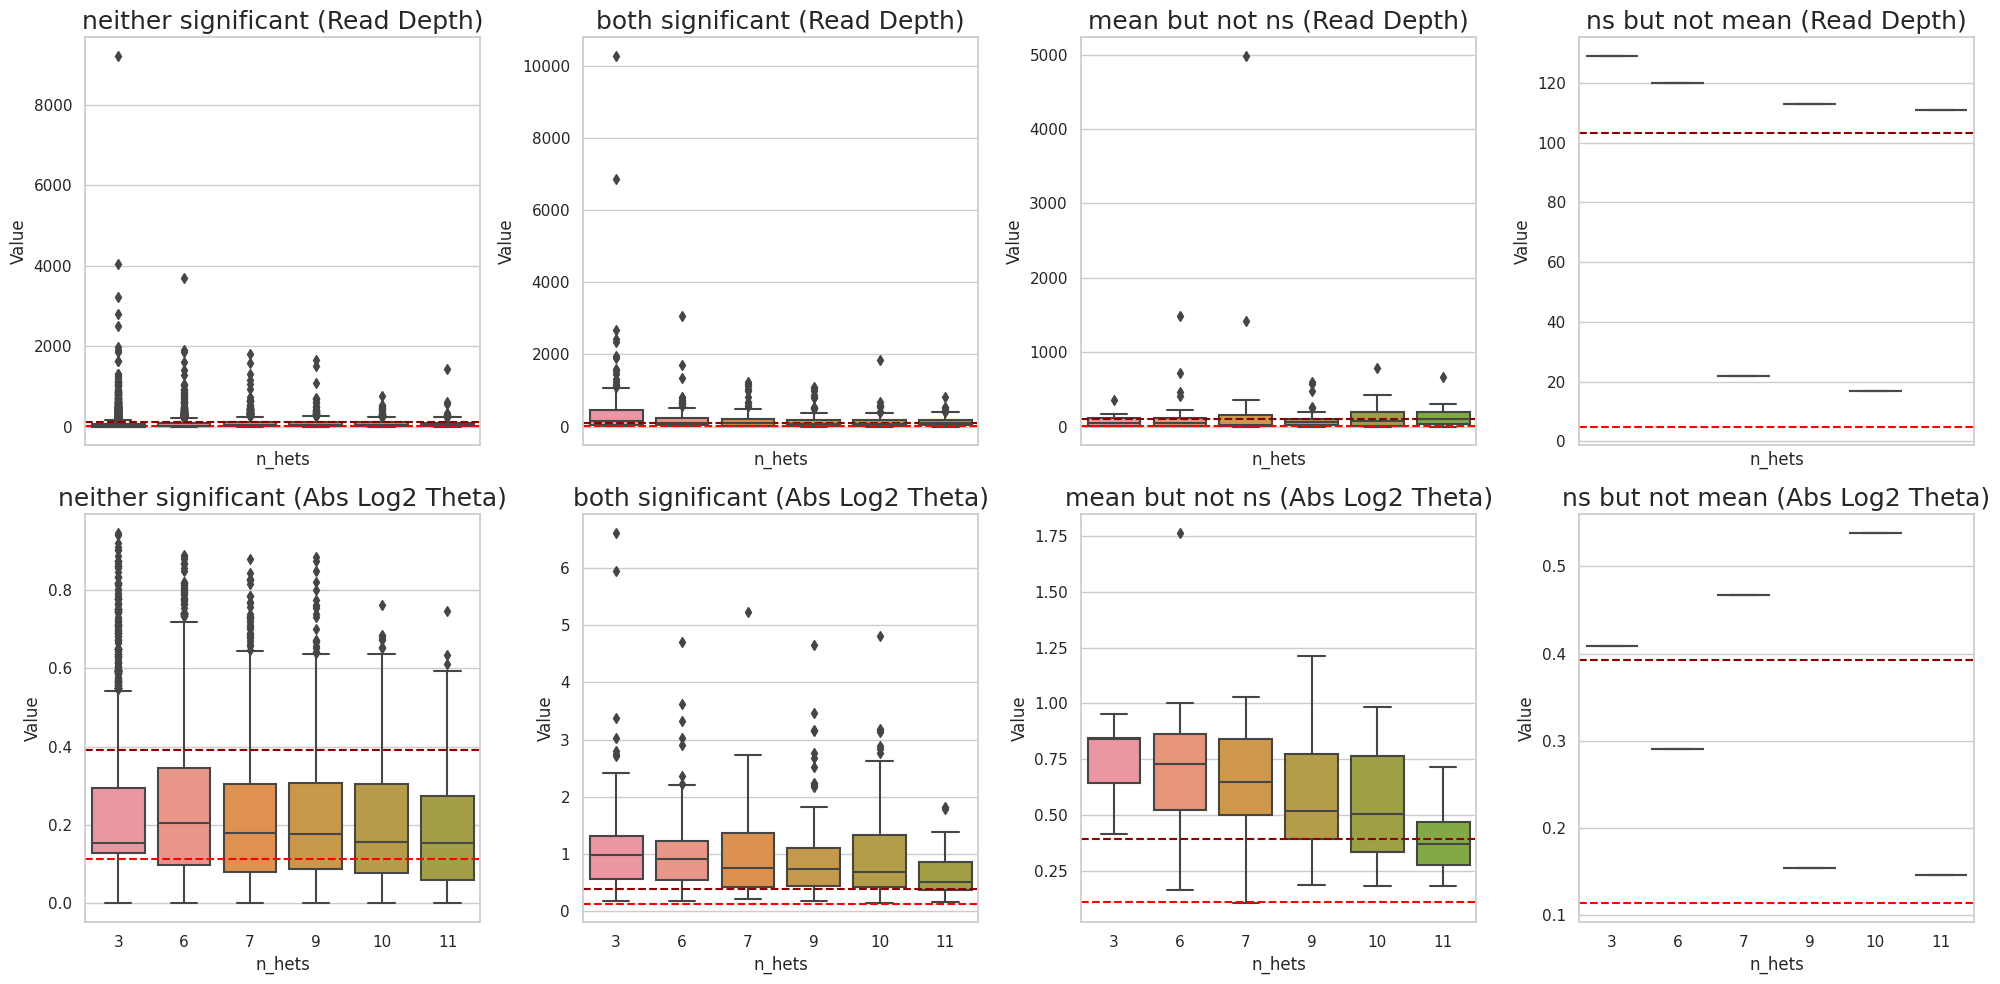

In [40]:
plot_coverage_hets_group_split4(df,'mean_st_corrected','ns_corrected','mean but not ns','ns but not mean')

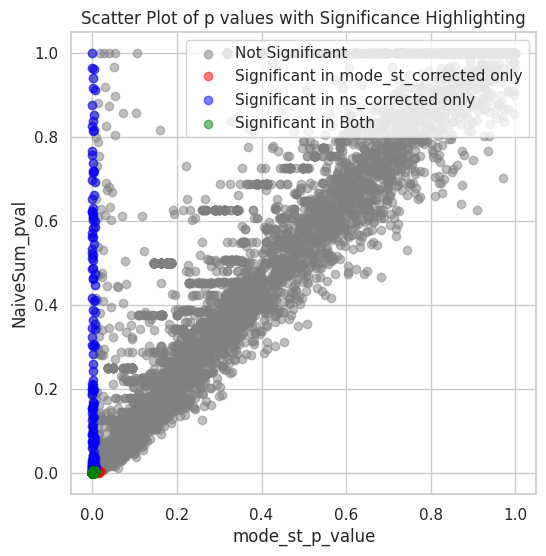

In [41]:
plot_2_columns(GIAB,'mode_st_corrected','ns_corrected','mode_st_p_value','NaiveSum_pval',"p values")

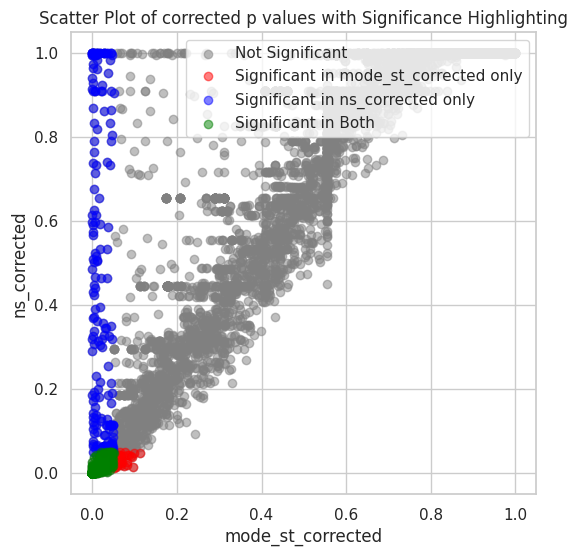

In [42]:
plot_2_columns(GIAB,'mode_st_corrected','ns_corrected','mode_st_corrected','ns_corrected',"corrected p values")

In [43]:
df = GIAB

mean_only_ASE = df.loc[mean_not_ns]
ns_only_ASE = df.loc[ns_not_mean]
both = df.loc[both_significant]

ns_only_ASE.sort_values(by=['NaiveSum_pval','mean_st_p_value'], ascending=[True,False]).head(n=20)

NameError: name 'mean_not_ns' is not defined

In [ ]:
mean_only_ASE.sort_values(by=['mean_st_p_value','NaiveSum_pval'], ascending=[True,False]).head(n=20)

NameError: name 'mean_only_ASE' is not defined

## QuickBEAST on 1000 Genome data

In [9]:
import os
import pandas as pd
import math

def read_and_merge_files(base_dir):
    all_data = []
    sample_count = 0

    # Iterate over each subdirectory in the base directory
    for subdir in os.listdir(base_dir):
        print(f"{subdir}-{sample_count+1}")
        subdir_path = os.path.join(base_dir, subdir)
        
        # Check if 'qb' folder exists in the subdirectory
        qb_dir = os.path.join(subdir_path, 'qb')
        if os.path.isdir(qb_dir):
            qb_file_name = f"{subdir}_qb_highestsite.tsv"
            qb_file_path = os.path.join(qb_dir, qb_file_name)
            binomial_file_path = os.path.join(qb_dir, f"{subdir}_binomial.tsv")
            # Check for the existence of the 'ancestry' file
            ancestry_file_path = os.path.join(subdir_path, 'ancestry')
            seq_file_path = os.path.join(subdir_path, 'filtered_mapped_seqDepth')
            
            # Read both files if they exist
            if os.path.isfile(qb_file_path) and os.path.isfile(ancestry_file_path):
                # Read qb file
                df = pd.read_csv(qb_file_path, sep='\t')
                df['sample'] = subdir  # Add a column for the sample name
                binomial = pd.read_csv(binomial_file_path, sep='\t')
                binomial['geneID'] = binomial['geneID'].str.split('.').str[0]
                binomial = binomial[["geneID","NaiveSum_pval","MajorSite_pval"]]
                # Read ancestry information
                with open(ancestry_file_path, 'r') as file:
                    ancestry = file.read().strip()
                # Read ancestry information
                with open(seq_file_path, 'r') as file:
                    seq = file.read().strip()
                df['ancestry'] = ancestry  # Add ancestry information
                df['seq_depth'] = seq
                # inner join df and binomial file
                joint = pd.merge(df, binomial, on=['geneID'])
                all_data.append(joint)
                sample_count += 1
            else:
                print(f"sample {subdir} does not have a 'qb' or 'ancestry' folder")
        else:
            print(f"sample {subdir} does not have a 'qb' folder")

    # Merge all dataframes into one
    merged_data = pd.concat(all_data, ignore_index=True)

    # filter GIAB with the conditions: (GIAB['qb_mean']!=0)&(GIAB['qb_mode']!=0)
    data = merged_data[merged_data['qb_mean']!=0]
    #data["total_count"] = data["total_readepth"]
    data["log2_theta"] = data["qb_mean"].apply(lambda x: (log2(((x)/(1-(x))))))
    data["abs_log2_theta"] = data["log2_theta"].apply(lambda x: abs(x))
    # filter out rows where mode_st_parameter_fit is not "PASSED", and remove this column
    data = data[data["mode_st_parameter_fit"]=="PASSED"]
    data.drop(columns=["mode_st_parameter_fit"], inplace=True)
    data["average_readepth"] = data["total_count"]/data["n_hets"]
    # create a column for abs_log2_theta
    # calculate the 25 and 75 quantile of abs_log2_theta
    Q1 = data["abs_log2_theta"].quantile(0.25)
    Q3 = data["abs_log2_theta"].quantile(0.75)
    print(Q1,Q3)

    # Print the number of samples read
    print(f"Number of samples read: {sample_count}")
    data.to_csv(f'/data2/1000Genome/{sample_count}_qb.tsv', sep='\t', index=False)
    return data

In [10]:
base_dir = "/data2/1000Genome"
onethousandgenome = read_and_merge_files(base_dir)

NA12829-1
NA20581-2
NA12272-3
NA11931-4
HG00269-5
HG00186-6
NA12717-7
NA10851-8
NA12890-9
NA18934-10
HG00242-11
NA19175-12
NA12347-13
NA20504-14
NA11894-15
NA19121-16
NA12045-17
HG00266-18
NA12775-19
HG00259-20
NA20531-21
NA11829-22
NA19171-23
HG00250-24
HG00335-25
NA11840-26
HG00146-27
NA20543-28
HG00245-29
NA19236-30
NA19131-31
NA18489-32
HG00156-33
sample HG00156 does not have a 'qb' or 'ancestry' folder
NA18933-33
NA20808-34
HG00280-35
HG00367-36
NA19184-37
NA19200-38
HG00239-39
NA20800-40
NA20771-41
NA19222-42
NA19095-43
NA12348-44
HG00351-45
HG00345-46
HG00312-47
sample HG00312 does not have a 'qb' or 'ancestry' folder
NA19141-47
NA20759-48
NA10847-49
NA11832-50
NA19117-51
NA20534-52
HG00151-53
NA20529-54
NA12751-55
HG00326-56
HG00342-57
HG00232-58
NA20539-59
HG00308-60
NA18861-61
NA07346-62
sample NA07346 does not have a 'qb' or 'ancestry' folder
HG00267-62
NA12761-63
HG02215-64
NA20514-65
HG00171-66
445_qb.tsv-67
sample 445_qb.tsv does not have a 'qb' folder
NA12889-67
HG00141-

/tmp/ipykernel_55756/4241426262.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["log2_theta"] = data["qb_mean"].apply(lambda x: (log2(((x)/(1-(x))))))
/tmp/ipykernel_55756/4241426262.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["abs_log2_theta"] = data["log2_theta"].apply(lambda x: abs(x))


0.11745503109848084 0.3596065917455587
Number of samples read: 445


In [42]:
onethousandgenome

NameError: name 'onethousandgenome' is not defined